In [1]:
from lib_linear import *
import  time
import torch.nn.functional as F

input_input_matrix = np.array(pd.read_csv('input_input_matrix.csv'))
output_input_matrix = np.array(pd.read_csv('output_input_matrix.csv'))
output_output_matrix = np.array(pd.read_csv('output_output_matrix.csv'))

V_matrix = np.array(pd.read_csv('V_matrix.csv'))
U_matrix = np.array(pd.read_csv('U_matrix.csv'))
S31_matrix = np.array(pd.read_csv('S_matrix.csv'))  ##actually, just diag values

S11_matrix = V_matrix.T @ input_input_matrix @ V_matrix
S33_matrix = output_output_matrix


## Data

In [2]:
mean, std = calculate_mean_and_std()
train_data, test_data =  download_normalized_data(mean, std)

## Neural network model

In [3]:
class CustomNetwork(object):
    
    """
    Simple D-layer linear neural network 
    hidden_dims = topule(n0, n1, n2, ...nD)
    n0 = input layer
    n_D = output layer
    """
    
    def __init__(self, D, layers_dim):
        
        """
        Initialize network's weights according to Gaussian iid and network's biases with 0.0 values
        """
        
        self.weights = []
        
        self.D = len(layers_dim)-1
        assert self.D == D
        
        print("Depth of the network = number of hidden layers + 1:", D)
        
        for i in range(self.D):
            
            weight: torch.Tensor = torch.rand((layers_dim[i+1], layers_dim[i])) 
            
            stdv = 2/ np.sqrt(layers_dim[i])
            
            weight = (weight-0.5)*stdv

            weight.requires_grad = True
            
            self.weights.append(weight)
       
            
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network
        """

        for i in range(0,self.D):            
            x = torch.nn.functional.linear( input = x, weight=self.weights[i])
        return x 
    
    
    
    def parameters(self) -> List[torch.Tensor]:
        """
        Returns all trainable parameters 
        """
        return self.weights

In [4]:
input_dim = 784
output_dim = 10
hidden_dim1 = 700

D = 2

# initialize the model
model: CustomNetwork = CustomNetwork(D = D, layers_dim = (input_dim, hidden_dim1, output_dim))

Depth of the network = number of hidden layers + 1: 2


## Training parameters

In [5]:
# initialize the optimizer using the hyperparams below
lr: float = 0.005
momentum: float = 0.00
optimizer: torch.optim.Optimizer = SGD(params = model.parameters(), lr=lr)
criterion = nn.MSELoss() 
epoch: int = 3000

## Training loop

In [6]:
term_I_tab=[]
term_II_tab = []
term_IV_tab = []
MSE_tab = []
R_tab = []

In [7]:
batch_size: int = 1000 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

for e in range(epoch):
    for inner_counter, (x, y) in enumerate(train_loader):

        # reset the gradients from previouis iteration
        optimizer.zero_grad()

        # pass through the network
        output: torch.Tensor = model(x)  
        y=F.one_hot(y, num_classes=10).float()
        loss: torch.Tensor = criterion(output, y)

        # backward pass thorught the network
        loss.backward()

        # apply the gradients
        optimizer.step()     

    
    #add model parameters to tab
    loss_tab.append(loss.item())
    params_tab = []
    for param in model.parameters():
        params_tab.append(param.detach().numpy().flatten()  )

    w1_mean_tab.append(params_tab[0].mean())
    w2_mean_tab.append(params_tab[1].mean())
    w1_std_tab.append(params_tab[0].std())
    w2_std_tab.append(params_tab[1].std())


    # at the end of an epoch run evaluation on the test set
    with torch.no_grad():
        correct: int = 0 
        for i, (x, y) in enumerate(train_loader):
            # pass through the network            
            output: torch.Tensor = model(x)
            # update the number of correctly predicted examples
            pred_labels = torch.argmax(output, 1)
            correct += ( (pred_labels -y) ==0).sum()
        train_accuracy_tab.append( float(correct) / len(train_data))

        correct: int = 0 
        for i, (x, y) in enumerate(test_loader):
            # pass through the network            
            output: torch.Tensor = model(x)

            # update the number of correctly predicted examples
            pred_labels = torch.argmax(output, 1)
            correct += ( (pred_labels -y) ==0).sum()
        test_accuracy_tab.append( float(correct) / len(test_data))

    ########################################################################
    params=[]
    for param in model.parameters():
        params.append(param.detach().numpy())
    w1=params[0] 
    w2=params[1]

    R = U_matrix.T @ w2 @ w1 @ V_matrix

    term_1 = 0
    for alpha in range(10):
        term_1 += (R[alpha][alpha] - S31_matrix[alpha]/S11_matrix[alpha][alpha])**2 * S11_matrix[alpha][alpha]

    term_2 = 0
    for beta in range(10):
        for alpha in range(784):
            if(alpha != beta):
                term_2 += (R[beta][alpha])**2 *S11_matrix[alpha][alpha]

    term_4 = 0
    for alpha in range(10):
        term_4+= (R[alpha][alpha])**2*S11_matrix[alpha][alpha]
    
    term_I_tab.append(term_1)
    term_II_tab.append(term_2)
    term_IV_tab.append(term_4)
    R_tab.append(R)

    term_1 = round(float(term_1), 6)
    term_2 = round(term_2, 6)

    check = round(1+ term_2 - term_4, 6)
    check2 = round(1+ term_1 + term_2 - term_4, 6)

    print(f"{e}\t{loss} \t term1: {term_1}, \t term2: {term_2} \t {check}\t {check2}")   



0	0.08645118027925491 	 term1: 0.074613, 	 term2: 0.392538 	 1.124842	 1.199455
1	0.06817638874053955 	 term1: 0.021906, 	 term2: 0.28557 	 0.888642	 0.910548
2	0.06061207130551338 	 term1: 0.008091, 	 term2: 0.237619 	 0.769396	 0.777487
3	0.05626143142580986 	 term1: 0.003871, 	 term2: 0.210453 	 0.69793	 0.701801
4	0.053372010588645935 	 term1: 0.002967, 	 term2: 0.19334 	 0.650227	 0.653194
5	0.05129414051771164 	 term1: 0.003384, 	 term2: 0.181856 	 0.616076	 0.61946
6	0.049718622118234634 	 term1: 0.004344, 	 term2: 0.173787 	 0.590402	 0.594746
7	0.04847690463066101 	 term1: 0.005506, 	 term2: 0.167904 	 0.570385	 0.575891
8	0.047468870878219604 	 term1: 0.006714, 	 term2: 0.16348 	 0.554335	 0.561049
9	0.04663124680519104 	 term1: 0.007895, 	 term2: 0.160062 	 0.541169	 0.549064
10	0.04592200741171837 	 term1: 0.009017, 	 term2: 0.157359 	 0.530167	 0.539184
11	0.04531211405992508 	 term1: 0.010066, 	 term2: 0.155178 	 0.520828	 0.530894
12	0.04478079080581665 	 term1: 0.01104,

102	0.0367799736559391 	 term1: 0.031343, 	 term2: 0.143377 	 0.408588	 0.439931
103	0.03675764054059982 	 term1: 0.03142, 	 term2: 0.143427 	 0.408352	 0.439772
104	0.03673560544848442 	 term1: 0.031496, 	 term2: 0.143478 	 0.40812	 0.439616
105	0.036713872104883194 	 term1: 0.031571, 	 term2: 0.143528 	 0.407891	 0.439462
106	0.03669242933392525 	 term1: 0.031646, 	 term2: 0.143579 	 0.407666	 0.439312
107	0.036671265959739685 	 term1: 0.03172, 	 term2: 0.143629 	 0.407443	 0.439163
108	0.036650389432907104 	 term1: 0.031793, 	 term2: 0.14368 	 0.407225	 0.439018
109	0.036629777401685715 	 term1: 0.031865, 	 term2: 0.143731 	 0.40701	 0.438875
110	0.03660944476723671 	 term1: 0.031937, 	 term2: 0.143782 	 0.406797	 0.438734
111	0.0365893691778183 	 term1: 0.032007, 	 term2: 0.143833 	 0.406588	 0.438595
112	0.03656954690814018 	 term1: 0.032077, 	 term2: 0.143884 	 0.406382	 0.438459
113	0.036549974232912064 	 term1: 0.032147, 	 term2: 0.143936 	 0.40618	 0.438327
114	0.0365306548774

203	0.035423316061496735 	 term1: 0.036483, 	 term2: 0.148297 	 0.395139	 0.431622
204	0.035415228456258774 	 term1: 0.036517, 	 term2: 0.14834 	 0.395065	 0.431582
205	0.03540720045566559 	 term1: 0.036551, 	 term2: 0.148383 	 0.394991	 0.431542
206	0.03539923578500748 	 term1: 0.036584, 	 term2: 0.148426 	 0.394918	 0.431502
207	0.03539133444428444 	 term1: 0.036618, 	 term2: 0.148469 	 0.394846	 0.431464
208	0.03538348525762558 	 term1: 0.036651, 	 term2: 0.148512 	 0.394775	 0.431426
209	0.03537570312619209 	 term1: 0.036684, 	 term2: 0.148554 	 0.394703	 0.431387
210	0.035367973148822784 	 term1: 0.036717, 	 term2: 0.148597 	 0.394633	 0.43135
211	0.03536031022667885 	 term1: 0.036749, 	 term2: 0.148639 	 0.394563	 0.431312
212	0.035352692008018494 	 term1: 0.036782, 	 term2: 0.148682 	 0.394494	 0.431276
213	0.03534513711929321 	 term1: 0.036814, 	 term2: 0.148724 	 0.394425	 0.431239
214	0.03533764183521271 	 term1: 0.036846, 	 term2: 0.148766 	 0.394357	 0.431203
215	0.03533019

304	0.03483410179615021 	 term1: 0.039111, 	 term2: 0.152042 	 0.389939	 0.42905
305	0.03482992947101593 	 term1: 0.039131, 	 term2: 0.152073 	 0.389904	 0.429035
306	0.034825779497623444 	 term1: 0.03915, 	 term2: 0.152105 	 0.389869	 0.429019
307	0.03482166305184364 	 term1: 0.03917, 	 term2: 0.152136 	 0.389835	 0.429005
308	0.03481756150722504 	 term1: 0.03919, 	 term2: 0.152167 	 0.3898	 0.42899
309	0.03481348231434822 	 term1: 0.039209, 	 term2: 0.152198 	 0.389766	 0.428975
310	0.034809429198503494 	 term1: 0.039228, 	 term2: 0.152228 	 0.38973	 0.428958
311	0.03480539470911026 	 term1: 0.039248, 	 term2: 0.152259 	 0.389697	 0.428945
312	0.034801382571458817 	 term1: 0.039267, 	 term2: 0.15229 	 0.389663	 0.42893
313	0.034797392785549164 	 term1: 0.039286, 	 term2: 0.15232 	 0.389629	 0.428915
314	0.0347934328019619 	 term1: 0.039305, 	 term2: 0.15235 	 0.389596	 0.428901
315	0.03478948771953583 	 term1: 0.039324, 	 term2: 0.152381 	 0.389563	 0.428887
316	0.034785568714141846 

405	0.03450654819607735 	 term1: 0.040734, 	 term2: 0.15475 	 0.387225	 0.427959
406	0.03450404852628708 	 term1: 0.040747, 	 term2: 0.154772 	 0.387203	 0.42795
407	0.034501560032367706 	 term1: 0.04076, 	 term2: 0.154795 	 0.387184	 0.427944
408	0.03449908271431923 	 term1: 0.040773, 	 term2: 0.154818 	 0.387164	 0.427937
409	0.03449661657214165 	 term1: 0.040786, 	 term2: 0.15484 	 0.387143	 0.427929
410	0.03449416533112526 	 term1: 0.040799, 	 term2: 0.154863 	 0.387124	 0.427923
411	0.03449171781539917 	 term1: 0.040811, 	 term2: 0.154885 	 0.387103	 0.427914
412	0.034489285200834274 	 term1: 0.040824, 	 term2: 0.154908 	 0.387084	 0.427908
413	0.034486863762140274 	 term1: 0.040837, 	 term2: 0.15493 	 0.387064	 0.427901
414	0.03448444977402687 	 term1: 0.040849, 	 term2: 0.154952 	 0.387044	 0.427893
415	0.03448205441236496 	 term1: 0.040862, 	 term2: 0.154975 	 0.387026	 0.427888
416	0.03447966277599335 	 term1: 0.040874, 	 term2: 0.154997 	 0.387006	 0.42788
417	0.0344772823154

506	0.03430146351456642 	 term1: 0.041837, 	 term2: 0.156748 	 0.385572	 0.427409
507	0.0342998243868351 	 term1: 0.041846, 	 term2: 0.156765 	 0.385559	 0.427405
508	0.03429819270968437 	 term1: 0.041855, 	 term2: 0.156782 	 0.385546	 0.427401
509	0.03429656848311424 	 term1: 0.041865, 	 term2: 0.156799 	 0.385533	 0.427398
510	0.03429495170712471 	 term1: 0.041874, 	 term2: 0.156816 	 0.38552	 0.427394
511	0.034293338656425476 	 term1: 0.041883, 	 term2: 0.156833 	 0.385507	 0.42739
512	0.03429173678159714 	 term1: 0.041892, 	 term2: 0.156849 	 0.385494	 0.427386
513	0.0342901349067688 	 term1: 0.041901, 	 term2: 0.156866 	 0.385481	 0.427382
514	0.03428853675723076 	 term1: 0.04191, 	 term2: 0.156883 	 0.385468	 0.427378
515	0.034286949783563614 	 term1: 0.041918, 	 term2: 0.1569 	 0.385456	 0.427374
516	0.034285370260477066 	 term1: 0.041927, 	 term2: 0.156916 	 0.385443	 0.42737
517	0.03428379446268082 	 term1: 0.041936, 	 term2: 0.156933 	 0.385431	 0.427367
518	0.034282222390174

607	0.034163154661655426 	 term1: 0.042634, 	 term2: 0.158264 	 0.384464	 0.427098
608	0.034162018448114395 	 term1: 0.042641, 	 term2: 0.158277 	 0.384455	 0.427096
609	0.03416088595986366 	 term1: 0.042648, 	 term2: 0.15829 	 0.384446	 0.427094
610	0.03415974974632263 	 term1: 0.042654, 	 term2: 0.158303 	 0.384437	 0.427091
611	0.034158624708652496 	 term1: 0.042661, 	 term2: 0.158316 	 0.384427	 0.427088
612	0.03415749967098236 	 term1: 0.042668, 	 term2: 0.15833 	 0.384419	 0.427087
613	0.03415638580918312 	 term1: 0.042675, 	 term2: 0.158343 	 0.384411	 0.427086
614	0.03415526822209358 	 term1: 0.042681, 	 term2: 0.158355 	 0.384401	 0.427082
615	0.03415415808558464 	 term1: 0.042688, 	 term2: 0.158368 	 0.384392	 0.42708
616	0.0341530479490757 	 term1: 0.042695, 	 term2: 0.158381 	 0.384383	 0.427078
617	0.034151941537857056 	 term1: 0.042701, 	 term2: 0.158394 	 0.384374	 0.427075
618	0.03415083885192871 	 term1: 0.042708, 	 term2: 0.158407 	 0.384365	 0.427073
619	0.0341497398

708	0.03406483307480812 	 term1: 0.043236, 	 term2: 0.159446 	 0.383671	 0.426907
709	0.034064002335071564 	 term1: 0.043241, 	 term2: 0.159456 	 0.383663	 0.426904
710	0.034063175320625305 	 term1: 0.043247, 	 term2: 0.159467 	 0.383657	 0.426904
711	0.034062352031469345 	 term1: 0.043252, 	 term2: 0.159477 	 0.38365	 0.426902
712	0.034061528742313385 	 term1: 0.043257, 	 term2: 0.159487 	 0.383643	 0.4269
713	0.03406071290373802 	 term1: 0.043262, 	 term2: 0.159498 	 0.383637	 0.426899
714	0.03405989706516266 	 term1: 0.043267, 	 term2: 0.159508 	 0.383631	 0.426898
715	0.034059081226587296 	 term1: 0.043273, 	 term2: 0.159518 	 0.383624	 0.426897
716	0.03405826911330223 	 term1: 0.043278, 	 term2: 0.159528 	 0.383617	 0.426895
717	0.034057460725307465 	 term1: 0.043283, 	 term2: 0.159539 	 0.383611	 0.426894
718	0.034056656062603 	 term1: 0.043288, 	 term2: 0.159549 	 0.383604	 0.426892
719	0.03405585139989853 	 term1: 0.043293, 	 term2: 0.159559 	 0.383598	 0.426891
720	0.034055043

809	0.03399204835295677 	 term1: 0.043707, 	 term2: 0.160389 	 0.383073	 0.42678
810	0.03399142622947693 	 term1: 0.043711, 	 term2: 0.160397 	 0.383068	 0.426779
811	0.03399080038070679 	 term1: 0.043715, 	 term2: 0.160406 	 0.383063	 0.426778
812	0.033990178257226944 	 term1: 0.043719, 	 term2: 0.160414 	 0.383058	 0.426777
813	0.0339895635843277 	 term1: 0.043723, 	 term2: 0.160422 	 0.383052	 0.426775
814	0.03398894518613815 	 term1: 0.043727, 	 term2: 0.160431 	 0.383048	 0.426775
815	0.03398832678794861 	 term1: 0.043731, 	 term2: 0.160439 	 0.383042	 0.426773
816	0.03398771211504936 	 term1: 0.043735, 	 term2: 0.160447 	 0.383037	 0.426772
817	0.033987097442150116 	 term1: 0.043739, 	 term2: 0.160456 	 0.383033	 0.426772
818	0.03398649021983147 	 term1: 0.043744, 	 term2: 0.160464 	 0.383027	 0.426771
819	0.03398587927222252 	 term1: 0.043748, 	 term2: 0.160472 	 0.383022	 0.42677
820	0.03398527204990387 	 term1: 0.043752, 	 term2: 0.16048 	 0.383017	 0.426769
821	0.033984661102

910	0.03393641486763954 	 term1: 0.044084, 	 term2: 0.161157 	 0.382607	 0.426691
911	0.03393593057990074 	 term1: 0.044087, 	 term2: 0.161164 	 0.382603	 0.42669
912	0.03393545001745224 	 term1: 0.044091, 	 term2: 0.161171 	 0.382599	 0.42669
913	0.03393496572971344 	 term1: 0.044094, 	 term2: 0.161178 	 0.382595	 0.426689
914	0.03393448516726494 	 term1: 0.044097, 	 term2: 0.161185 	 0.382591	 0.426688
915	0.03393400460481644 	 term1: 0.044101, 	 term2: 0.161191 	 0.382586	 0.426687
916	0.033933524042367935 	 term1: 0.044104, 	 term2: 0.161198 	 0.382582	 0.426686
917	0.03393304720520973 	 term1: 0.044107, 	 term2: 0.161205 	 0.382579	 0.426686
918	0.03393257409334183 	 term1: 0.044111, 	 term2: 0.161212 	 0.382575	 0.426686
919	0.033932093530893326 	 term1: 0.044114, 	 term2: 0.161219 	 0.382571	 0.426685
920	0.03393162414431572 	 term1: 0.044117, 	 term2: 0.161225 	 0.382566	 0.426683
921	0.033931151032447815 	 term1: 0.044121, 	 term2: 0.161232 	 0.382562	 0.426683
922	0.033930677

1011	0.03389275446534157 	 term1: 0.044394, 	 term2: 0.161794 	 0.382233	 0.426627
1012	0.03389236330986023 	 term1: 0.044396, 	 term2: 0.161799 	 0.382229	 0.426625
1013	0.033891987055540085 	 term1: 0.044399, 	 term2: 0.161805 	 0.382226	 0.426625
1014	0.03389160335063934 	 term1: 0.044402, 	 term2: 0.161811 	 0.382223	 0.426625
1015	0.0338912159204483 	 term1: 0.044405, 	 term2: 0.161817 	 0.38222	 0.426625
1016	0.03389083594083786 	 term1: 0.044407, 	 term2: 0.161822 	 0.382216	 0.426623
1017	0.03389045596122742 	 term1: 0.04441, 	 term2: 0.161828 	 0.382213	 0.426623
1018	0.033890075981616974 	 term1: 0.044413, 	 term2: 0.161834 	 0.38221	 0.426623
1019	0.03388969600200653 	 term1: 0.044416, 	 term2: 0.16184 	 0.382207	 0.426623
1020	0.033889319747686386 	 term1: 0.044418, 	 term2: 0.161845 	 0.382203	 0.426621
1021	0.03388894349336624 	 term1: 0.044421, 	 term2: 0.161851 	 0.3822	 0.426621
1022	0.033888570964336395 	 term1: 0.044424, 	 term2: 0.161857 	 0.382197	 0.426621
1023	0.

1111	0.0338580459356308 	 term1: 0.04465, 	 term2: 0.162325 	 0.381928	 0.426578
1112	0.033857736736536026 	 term1: 0.044652, 	 term2: 0.162329 	 0.381924	 0.426576
1113	0.033857423812150955 	 term1: 0.044654, 	 term2: 0.162334 	 0.381922	 0.426576
1114	0.033857110887765884 	 term1: 0.044657, 	 term2: 0.162339 	 0.381919	 0.426576
1115	0.03385680168867111 	 term1: 0.044659, 	 term2: 0.162344 	 0.381916	 0.426575
1116	0.03385648876428604 	 term1: 0.044661, 	 term2: 0.162349 	 0.381914	 0.426575
1117	0.03385618329048157 	 term1: 0.044664, 	 term2: 0.162354 	 0.381911	 0.426575
1118	0.033855874091386795 	 term1: 0.044666, 	 term2: 0.162359 	 0.381909	 0.426575
1119	0.03385556489229202 	 term1: 0.044668, 	 term2: 0.162363 	 0.381905	 0.426573
1120	0.03385525941848755 	 term1: 0.044671, 	 term2: 0.162368 	 0.381902	 0.426573
1121	0.03385495766997337 	 term1: 0.044673, 	 term2: 0.162373 	 0.3819	 0.426573
1122	0.0338546484708786 	 term1: 0.044675, 	 term2: 0.162378 	 0.381897	 0.426572
1123	

1210	0.033829908818006516 	 term1: 0.044865, 	 term2: 0.162774 	 0.381674	 0.426539
1211	0.033829644322395325 	 term1: 0.044867, 	 term2: 0.162778 	 0.381671	 0.426538
1212	0.03382938727736473 	 term1: 0.044869, 	 term2: 0.162782 	 0.381669	 0.426538
1213	0.03382913023233414 	 term1: 0.044871, 	 term2: 0.162787 	 0.381667	 0.426538
1214	0.03382887691259384 	 term1: 0.044873, 	 term2: 0.162791 	 0.381665	 0.426538
1215	0.03382861986756325 	 term1: 0.044875, 	 term2: 0.162795 	 0.381662	 0.426537
1216	0.033828362822532654 	 term1: 0.044877, 	 term2: 0.162799 	 0.38166	 0.426537
1217	0.03382810950279236 	 term1: 0.044879, 	 term2: 0.162803 	 0.381657	 0.426536
1218	0.033827848732471466 	 term1: 0.044881, 	 term2: 0.162807 	 0.381655	 0.426536
1219	0.03382760286331177 	 term1: 0.044883, 	 term2: 0.162812 	 0.381653	 0.426536
1220	0.033827342092990875 	 term1: 0.044885, 	 term2: 0.162816 	 0.381651	 0.426536
1221	0.03382708877325058 	 term1: 0.044887, 	 term2: 0.16282 	 0.381648	 0.426535
1

1309	0.03380648419260979 	 term1: 0.04505, 	 term2: 0.163163 	 0.381457	 0.426507
1310	0.03380626440048218 	 term1: 0.045052, 	 term2: 0.163166 	 0.381455	 0.426507
1311	0.03380604833364487 	 term1: 0.045054, 	 term2: 0.16317 	 0.381453	 0.426507
1312	0.03380583971738815 	 term1: 0.045056, 	 term2: 0.163174 	 0.381451	 0.426507
1313	0.033805619925260544 	 term1: 0.045057, 	 term2: 0.163177 	 0.381449	 0.426506
1314	0.03380540385842323 	 term1: 0.045059, 	 term2: 0.163181 	 0.381447	 0.426506
1315	0.03380518779158592 	 term1: 0.045061, 	 term2: 0.163185 	 0.381445	 0.426506
1316	0.03380497545003891 	 term1: 0.045062, 	 term2: 0.163188 	 0.381443	 0.426505
1317	0.0338047593832016 	 term1: 0.045064, 	 term2: 0.163192 	 0.381441	 0.426505
1318	0.03380454704165459 	 term1: 0.045066, 	 term2: 0.163196 	 0.381439	 0.426505
1319	0.033804334700107574 	 term1: 0.045068, 	 term2: 0.163199 	 0.381437	 0.426505
1320	0.033804118633270264 	 term1: 0.045069, 	 term2: 0.163203 	 0.381435	 0.426504
1321

1409	0.03378654643893242 	 term1: 0.045213, 	 term2: 0.163506 	 0.381268	 0.426481
1410	0.033786363899707794 	 term1: 0.045215, 	 term2: 0.163509 	 0.381266	 0.426481
1411	0.03378617763519287 	 term1: 0.045216, 	 term2: 0.163512 	 0.381264	 0.42648
1412	0.033785998821258545 	 term1: 0.045218, 	 term2: 0.163516 	 0.381263	 0.426481
1413	0.03378581628203392 	 term1: 0.045219, 	 term2: 0.163519 	 0.381261	 0.42648
1414	0.033785633742809296 	 term1: 0.045221, 	 term2: 0.163522 	 0.381259	 0.42648
1415	0.03378545120358467 	 term1: 0.045222, 	 term2: 0.163525 	 0.381258	 0.42648
1416	0.033785268664360046 	 term1: 0.045224, 	 term2: 0.163528 	 0.381256	 0.42648
1417	0.03378509357571602 	 term1: 0.045225, 	 term2: 0.163532 	 0.381255	 0.42648
1418	0.033784911036491394 	 term1: 0.045227, 	 term2: 0.163535 	 0.381253	 0.42648
1419	0.03378472849726677 	 term1: 0.045228, 	 term2: 0.163538 	 0.381251	 0.426479
1420	0.033784545958042145 	 term1: 0.04523, 	 term2: 0.163541 	 0.381249	 0.426479
1421	0

1508	0.03376974165439606 	 term1: 0.045355, 	 term2: 0.163805 	 0.381104	 0.426459
1509	0.03376958519220352 	 term1: 0.045356, 	 term2: 0.163808 	 0.381103	 0.426459
1510	0.033769428730010986 	 term1: 0.045358, 	 term2: 0.163811 	 0.381102	 0.42646
1511	0.03376927599310875 	 term1: 0.045359, 	 term2: 0.163814 	 0.3811	 0.426459
1512	0.033769119530916214 	 term1: 0.04536, 	 term2: 0.163817 	 0.381099	 0.426459
1513	0.03376895934343338 	 term1: 0.045362, 	 term2: 0.163819 	 0.381096	 0.426458
1514	0.03376880660653114 	 term1: 0.045363, 	 term2: 0.163822 	 0.381095	 0.426458
1515	0.033768653869628906 	 term1: 0.045364, 	 term2: 0.163825 	 0.381094	 0.426458
1516	0.03376849368214607 	 term1: 0.045366, 	 term2: 0.163828 	 0.381092	 0.426458
1517	0.03376833721995354 	 term1: 0.045367, 	 term2: 0.163831 	 0.381091	 0.426458
1518	0.033768180757761 	 term1: 0.045368, 	 term2: 0.163834 	 0.38109	 0.426458
1519	0.033768028020858765 	 term1: 0.04537, 	 term2: 0.163836 	 0.381087	 0.426457
1520	0.0

1607	0.033755283802747726 	 term1: 0.045481, 	 term2: 0.164071 	 0.38096	 0.426441
1608	0.03375514969229698 	 term1: 0.045482, 	 term2: 0.164074 	 0.380959	 0.426441
1609	0.03375501558184624 	 term1: 0.045483, 	 term2: 0.164077 	 0.380958	 0.426441
1610	0.033754877746105194 	 term1: 0.045484, 	 term2: 0.164079 	 0.380956	 0.42644
1611	0.03375474363565445 	 term1: 0.045485, 	 term2: 0.164082 	 0.380955	 0.42644
1612	0.033754605799913406 	 term1: 0.045487, 	 term2: 0.164084 	 0.380954	 0.426441
1613	0.03375447168946266 	 term1: 0.045488, 	 term2: 0.164087 	 0.380953	 0.426441
1614	0.03375433757901192 	 term1: 0.045489, 	 term2: 0.164089 	 0.380951	 0.42644
1615	0.03375420346856117 	 term1: 0.04549, 	 term2: 0.164092 	 0.38095	 0.42644
1616	0.03375406563282013 	 term1: 0.045491, 	 term2: 0.164094 	 0.380948	 0.426439
1617	0.03375393524765968 	 term1: 0.045493, 	 term2: 0.164097 	 0.380947	 0.42644
1618	0.03375380113720894 	 term1: 0.045494, 	 term2: 0.164099 	 0.380945	 0.426439
1619	0.03

1706	0.03374272584915161 	 term1: 0.045593, 	 term2: 0.16431 	 0.380832	 0.426425
1707	0.03374261036515236 	 term1: 0.045594, 	 term2: 0.164312 	 0.380831	 0.426425
1708	0.03374248743057251 	 term1: 0.045595, 	 term2: 0.164314 	 0.380829	 0.426424
1709	0.03374237194657326 	 term1: 0.045596, 	 term2: 0.164317 	 0.380829	 0.426425
1710	0.03374225273728371 	 term1: 0.045597, 	 term2: 0.164319 	 0.380827	 0.426424
1711	0.033742137253284454 	 term1: 0.045598, 	 term2: 0.164321 	 0.380826	 0.426424
1712	0.033742018043994904 	 term1: 0.045599, 	 term2: 0.164323 	 0.380824	 0.426423
1713	0.03374189883470535 	 term1: 0.0456, 	 term2: 0.164326 	 0.380824	 0.426424
1714	0.0337417833507061 	 term1: 0.045601, 	 term2: 0.164328 	 0.380822	 0.426423
1715	0.03374166414141655 	 term1: 0.045602, 	 term2: 0.16433 	 0.380821	 0.426423
1716	0.033741552382707596 	 term1: 0.045603, 	 term2: 0.164332 	 0.380819	 0.426422
1717	0.03374142944812775 	 term1: 0.045605, 	 term2: 0.164335 	 0.380819	 0.426424
1718	0

1806	0.033731650561094284 	 term1: 0.045695, 	 term2: 0.164527 	 0.380716	 0.426411
1807	0.03373154625296593 	 term1: 0.045696, 	 term2: 0.164529 	 0.380715	 0.426411
1808	0.03373144194483757 	 term1: 0.045697, 	 term2: 0.164531 	 0.380714	 0.426411
1809	0.03373133763670921 	 term1: 0.045698, 	 term2: 0.164533 	 0.380713	 0.426411
1810	0.033731237053871155 	 term1: 0.045699, 	 term2: 0.164535 	 0.380711	 0.42641
1811	0.0337311327457428 	 term1: 0.0457, 	 term2: 0.164537 	 0.38071	 0.42641
1812	0.03373102843761444 	 term1: 0.0457, 	 term2: 0.164539 	 0.380709	 0.426409
1813	0.03373092785477638 	 term1: 0.045701, 	 term2: 0.164541 	 0.380708	 0.426409
1814	0.033730823546648026 	 term1: 0.045702, 	 term2: 0.164543 	 0.380707	 0.426409
1815	0.033730726689100266 	 term1: 0.045703, 	 term2: 0.164545 	 0.380706	 0.426409
1816	0.03373061493039131 	 term1: 0.045704, 	 term2: 0.164547 	 0.380705	 0.426409
1817	0.03373051807284355 	 term1: 0.045705, 	 term2: 0.164549 	 0.380703	 0.426408
1818	0.0

1906	0.033721912652254105 	 term1: 0.045787, 	 term2: 0.164723 	 0.380611	 0.426398
1907	0.03372181951999664 	 term1: 0.045788, 	 term2: 0.164725 	 0.38061	 0.426398
1908	0.03372173011302948 	 term1: 0.045788, 	 term2: 0.164727 	 0.380609	 0.426397
1909	0.03372163325548172 	 term1: 0.045789, 	 term2: 0.164729 	 0.380608	 0.426397
1910	0.03372154384851456 	 term1: 0.04579, 	 term2: 0.16473 	 0.380606	 0.426396
1911	0.033721454441547394 	 term1: 0.045791, 	 term2: 0.164732 	 0.380605	 0.426396
1912	0.03372136130928993 	 term1: 0.045792, 	 term2: 0.164734 	 0.380605	 0.426397
1913	0.03372127190232277 	 term1: 0.045793, 	 term2: 0.164736 	 0.380604	 0.426397
1914	0.033721182495355606 	 term1: 0.045794, 	 term2: 0.164738 	 0.380603	 0.426397
1915	0.033721089363098145 	 term1: 0.045795, 	 term2: 0.16474 	 0.380602	 0.426397
1916	0.03372100368142128 	 term1: 0.045795, 	 term2: 0.164742 	 0.380601	 0.426396
1917	0.03372091054916382 	 term1: 0.045796, 	 term2: 0.164743 	 0.380599	 0.426395
1918

2005	0.03371339291334152 	 term1: 0.04587, 	 term2: 0.1649 	 0.380516	 0.426386
2006	0.033713310956954956 	 term1: 0.04587, 	 term2: 0.164902 	 0.380516	 0.426386
2007	0.03371322900056839 	 term1: 0.045871, 	 term2: 0.164903 	 0.380514	 0.426385
2008	0.033713147044181824 	 term1: 0.045872, 	 term2: 0.164905 	 0.380514	 0.426386
2009	0.033713068813085556 	 term1: 0.045873, 	 term2: 0.164907 	 0.380513	 0.426386
2010	0.03371298313140869 	 term1: 0.045874, 	 term2: 0.164909 	 0.380512	 0.426386
2011	0.033712901175022125 	 term1: 0.045874, 	 term2: 0.16491 	 0.380511	 0.426385
2012	0.03371282294392586 	 term1: 0.045875, 	 term2: 0.164912 	 0.38051	 0.426385
2013	0.03371274471282959 	 term1: 0.045876, 	 term2: 0.164914 	 0.38051	 0.426386
2014	0.033712662756443024 	 term1: 0.045877, 	 term2: 0.164915 	 0.380508	 0.426385
2015	0.03371258080005646 	 term1: 0.045878, 	 term2: 0.164917 	 0.380507	 0.426385
2016	0.03371250256896019 	 term1: 0.045878, 	 term2: 0.164919 	 0.380507	 0.426385
2017	0

2104	0.03370579704642296 	 term1: 0.045945, 	 term2: 0.165062 	 0.38043	 0.426375
2105	0.03370572254061699 	 term1: 0.045946, 	 term2: 0.165064 	 0.38043	 0.426376
2106	0.03370564803481102 	 term1: 0.045947, 	 term2: 0.165065 	 0.380428	 0.426375
2107	0.03370557725429535 	 term1: 0.045948, 	 term2: 0.165067 	 0.380428	 0.426376
2108	0.03370550647377968 	 term1: 0.045948, 	 term2: 0.165068 	 0.380427	 0.426375
2109	0.03370543196797371 	 term1: 0.045949, 	 term2: 0.16507 	 0.380426	 0.426375
2110	0.03370536118745804 	 term1: 0.04595, 	 term2: 0.165072 	 0.380426	 0.426376
2111	0.03370529040694237 	 term1: 0.04595, 	 term2: 0.165073 	 0.380424	 0.426374
2112	0.033705223351716995 	 term1: 0.045951, 	 term2: 0.165075 	 0.380424	 0.426375
2113	0.03370514512062073 	 term1: 0.045952, 	 term2: 0.165076 	 0.380423	 0.426375
2114	0.03370507061481476 	 term1: 0.045953, 	 term2: 0.165078 	 0.380422	 0.426375
2115	0.033705003559589386 	 term1: 0.045953, 	 term2: 0.165079 	 0.380421	 0.426374
2116	0.

2204	0.03369894251227379 	 term1: 0.046015, 	 term2: 0.165213 	 0.380351	 0.426366
2205	0.03369888290762901 	 term1: 0.046016, 	 term2: 0.165214 	 0.38035	 0.426366
2206	0.03369881585240364 	 term1: 0.046017, 	 term2: 0.165215 	 0.380349	 0.426366
2207	0.033698756247758865 	 term1: 0.046017, 	 term2: 0.165217 	 0.380349	 0.426366
2208	0.033698685467243195 	 term1: 0.046018, 	 term2: 0.165218 	 0.380347	 0.426365
2209	0.03369862213730812 	 term1: 0.046019, 	 term2: 0.16522 	 0.380347	 0.426366
2210	0.03369855508208275 	 term1: 0.046019, 	 term2: 0.165221 	 0.380346	 0.426365
2211	0.033698491752147675 	 term1: 0.04602, 	 term2: 0.165223 	 0.380346	 0.426366
2212	0.0336984284222126 	 term1: 0.046021, 	 term2: 0.165224 	 0.380345	 0.426366
2213	0.03369836509227753 	 term1: 0.046021, 	 term2: 0.165226 	 0.380344	 0.426365
2214	0.03369830176234245 	 term1: 0.046022, 	 term2: 0.165227 	 0.380343	 0.426365
2215	0.03369823843240738 	 term1: 0.046023, 	 term2: 0.165228 	 0.380342	 0.426365
2216	

2303	0.0336928628385067 	 term1: 0.046079, 	 term2: 0.16535 	 0.380278	 0.426357
2304	0.03369280323386192 	 term1: 0.04608, 	 term2: 0.165351 	 0.380277	 0.426357
2305	0.033692747354507446 	 term1: 0.046081, 	 term2: 0.165353 	 0.380277	 0.426358
2306	0.03369268774986267 	 term1: 0.046081, 	 term2: 0.165354 	 0.380276	 0.426357
2307	0.033692628145217896 	 term1: 0.046082, 	 term2: 0.165355 	 0.380275	 0.426357
2308	0.03369257226586342 	 term1: 0.046083, 	 term2: 0.165357 	 0.380275	 0.426358
2309	0.03369251266121864 	 term1: 0.046083, 	 term2: 0.165358 	 0.380274	 0.426357
2310	0.03369245305657387 	 term1: 0.046084, 	 term2: 0.165359 	 0.380273	 0.426357
2311	0.03369239717721939 	 term1: 0.046084, 	 term2: 0.165361 	 0.380273	 0.426357
2312	0.033692341297864914 	 term1: 0.046085, 	 term2: 0.165362 	 0.380272	 0.426357
2313	0.03369228169322014 	 term1: 0.046086, 	 term2: 0.165363 	 0.380271	 0.426357
2314	0.03369222581386566 	 term1: 0.046086, 	 term2: 0.165365 	 0.380271	 0.426357
2315

2402	0.033687375485897064 	 term1: 0.046139, 	 term2: 0.165477 	 0.380211	 0.42635
2403	0.033687323331832886 	 term1: 0.046139, 	 term2: 0.165479 	 0.380211	 0.42635
2404	0.033687274903059006 	 term1: 0.04614, 	 term2: 0.16548 	 0.38021	 0.42635
2405	0.03368721529841423 	 term1: 0.04614, 	 term2: 0.165481 	 0.380209	 0.426349
2406	0.03368717059493065 	 term1: 0.046141, 	 term2: 0.165482 	 0.380208	 0.426349
2407	0.03368711471557617 	 term1: 0.046142, 	 term2: 0.165484 	 0.380208	 0.42635
2408	0.03368706256151199 	 term1: 0.046142, 	 term2: 0.165485 	 0.380207	 0.426349
2409	0.033687010407447815 	 term1: 0.046143, 	 term2: 0.165486 	 0.380206	 0.426349
2410	0.033686958253383636 	 term1: 0.046143, 	 term2: 0.165487 	 0.380205	 0.426348
2411	0.03368690237402916 	 term1: 0.046144, 	 term2: 0.165489 	 0.380206	 0.42635
2412	0.03368685767054558 	 term1: 0.046144, 	 term2: 0.16549 	 0.380205	 0.426349
2413	0.0336868017911911 	 term1: 0.046145, 	 term2: 0.165491 	 0.380204	 0.426349
2414	0.033

2501	0.033682409673929214 	 term1: 0.046194, 	 term2: 0.165596 	 0.380149	 0.426343
2502	0.033682361245155334 	 term1: 0.046194, 	 term2: 0.165597 	 0.380148	 0.426342
2503	0.03368231654167175 	 term1: 0.046195, 	 term2: 0.165598 	 0.380147	 0.426342
2504	0.033682264387607574 	 term1: 0.046195, 	 term2: 0.165599 	 0.380146	 0.426341
2505	0.033682215958833694 	 term1: 0.046196, 	 term2: 0.165601 	 0.380147	 0.426343
2506	0.03368217125535011 	 term1: 0.046196, 	 term2: 0.165602 	 0.380146	 0.426342
2507	0.03368212282657623 	 term1: 0.046197, 	 term2: 0.165603 	 0.380145	 0.426342
2508	0.03368207439780235 	 term1: 0.046197, 	 term2: 0.165604 	 0.380144	 0.426341
2509	0.03368202969431877 	 term1: 0.046198, 	 term2: 0.165605 	 0.380144	 0.426342
2510	0.03368197754025459 	 term1: 0.046199, 	 term2: 0.165606 	 0.380143	 0.426342
2511	0.03368193283677101 	 term1: 0.046199, 	 term2: 0.165607 	 0.380142	 0.426341
2512	0.03368188440799713 	 term1: 0.0462, 	 term2: 0.165609 	 0.380142	 0.426342
25

2601	0.0336778499186039 	 term1: 0.046245, 	 term2: 0.165708 	 0.38009	 0.426335
2602	0.033677808940410614 	 term1: 0.046246, 	 term2: 0.165709 	 0.38009	 0.426336
2603	0.03367776423692703 	 term1: 0.046246, 	 term2: 0.16571 	 0.380089	 0.426335
2604	0.03367772698402405 	 term1: 0.046247, 	 term2: 0.165711 	 0.380089	 0.426336
2605	0.03367767855525017 	 term1: 0.046247, 	 term2: 0.165712 	 0.380088	 0.426335
2606	0.03367764130234718 	 term1: 0.046248, 	 term2: 0.165713 	 0.380087	 0.426335
2607	0.0336775928735733 	 term1: 0.046248, 	 term2: 0.165714 	 0.380087	 0.426335
2608	0.03367755189538002 	 term1: 0.046249, 	 term2: 0.165715 	 0.380086	 0.426335
2609	0.03367751091718674 	 term1: 0.046249, 	 term2: 0.165716 	 0.380085	 0.426334
2610	0.033677466213703156 	 term1: 0.04625, 	 term2: 0.165717 	 0.380085	 0.426335
2611	0.033677421510219574 	 term1: 0.04625, 	 term2: 0.165718 	 0.380084	 0.426334
2612	0.03367738053202629 	 term1: 0.046251, 	 term2: 0.165719 	 0.380083	 0.426334
2613	0.0

2700	0.03367374464869499 	 term1: 0.046293, 	 term2: 0.165811 	 0.380036	 0.426329
2701	0.03367370739579201 	 term1: 0.046294, 	 term2: 0.165812 	 0.380036	 0.42633
2702	0.03367367014288902 	 term1: 0.046294, 	 term2: 0.165813 	 0.380035	 0.426329
2703	0.03367362543940544 	 term1: 0.046295, 	 term2: 0.165814 	 0.380034	 0.426329
2704	0.033673591911792755 	 term1: 0.046295, 	 term2: 0.165815 	 0.380034	 0.426329
2705	0.03367355093359947 	 term1: 0.046296, 	 term2: 0.165816 	 0.380033	 0.426329
2706	0.03367350623011589 	 term1: 0.046296, 	 term2: 0.165817 	 0.380033	 0.426329
2707	0.033673472702503204 	 term1: 0.046296, 	 term2: 0.165818 	 0.380032	 0.426328
2708	0.03367343172430992 	 term1: 0.046297, 	 term2: 0.165819 	 0.380032	 0.426329
2709	0.03367339447140694 	 term1: 0.046297, 	 term2: 0.16582 	 0.380031	 0.426328
2710	0.033673353493213654 	 term1: 0.046298, 	 term2: 0.165821 	 0.380031	 0.426329
2711	0.03367331624031067 	 term1: 0.046298, 	 term2: 0.165822 	 0.38003	 0.426328
2712

2799	0.03366999328136444 	 term1: 0.046338, 	 term2: 0.165908 	 0.379985	 0.426323
2800	0.03366996347904205 	 term1: 0.046338, 	 term2: 0.165909 	 0.379985	 0.426323
2801	0.03366992622613907 	 term1: 0.046339, 	 term2: 0.16591 	 0.379985	 0.426324
2802	0.03366989269852638 	 term1: 0.046339, 	 term2: 0.16591 	 0.379983	 0.426322
2803	0.0336698554456234 	 term1: 0.04634, 	 term2: 0.165911 	 0.379983	 0.426323
2804	0.03366981819272041 	 term1: 0.04634, 	 term2: 0.165912 	 0.379982	 0.426322
2805	0.03366978466510773 	 term1: 0.046341, 	 term2: 0.165913 	 0.379982	 0.426323
2806	0.033669743686914444 	 term1: 0.046341, 	 term2: 0.165914 	 0.379981	 0.426322
2807	0.033669713884592056 	 term1: 0.046341, 	 term2: 0.165915 	 0.379981	 0.426322
2808	0.03366967290639877 	 term1: 0.046342, 	 term2: 0.165916 	 0.379981	 0.426323
2809	0.03366963937878609 	 term1: 0.046342, 	 term2: 0.165917 	 0.37998	 0.426322
2810	0.0336696058511734 	 term1: 0.046343, 	 term2: 0.165918 	 0.37998	 0.426323
2811	0.033

2899	0.03366653621196747 	 term1: 0.04638, 	 term2: 0.166 	 0.379937	 0.426317
2900	0.03366650268435478 	 term1: 0.046381, 	 term2: 0.166 	 0.379936	 0.426317
2901	0.0336664654314518 	 term1: 0.046381, 	 term2: 0.166001 	 0.379936	 0.426317
2902	0.03366643190383911 	 term1: 0.046382, 	 term2: 0.166002 	 0.379935	 0.426317
2903	0.033666402101516724 	 term1: 0.046382, 	 term2: 0.166003 	 0.379935	 0.426317
2904	0.03366636857390404 	 term1: 0.046383, 	 term2: 0.166004 	 0.379935	 0.426318
2905	0.03366633504629135 	 term1: 0.046383, 	 term2: 0.166005 	 0.379934	 0.426317
2906	0.03366629779338837 	 term1: 0.046383, 	 term2: 0.166006 	 0.379934	 0.426317
2907	0.03366626799106598 	 term1: 0.046384, 	 term2: 0.166007 	 0.379934	 0.426318
2908	0.03366623446345329 	 term1: 0.046384, 	 term2: 0.166008 	 0.379933	 0.426317
2909	0.033666204661130905 	 term1: 0.046385, 	 term2: 0.166008 	 0.379932	 0.426317
2910	0.03366616740822792 	 term1: 0.046385, 	 term2: 0.166009 	 0.379932	 0.426317
2911	0.033

2998	0.03366338461637497 	 term1: 0.04642, 	 term2: 0.166085 	 0.379892	 0.426312
2999	0.033663347363471985 	 term1: 0.04642, 	 term2: 0.166086 	 0.379892	 0.426312


## Time evolution of loss, accuracy, $T_1$ and $T_2$

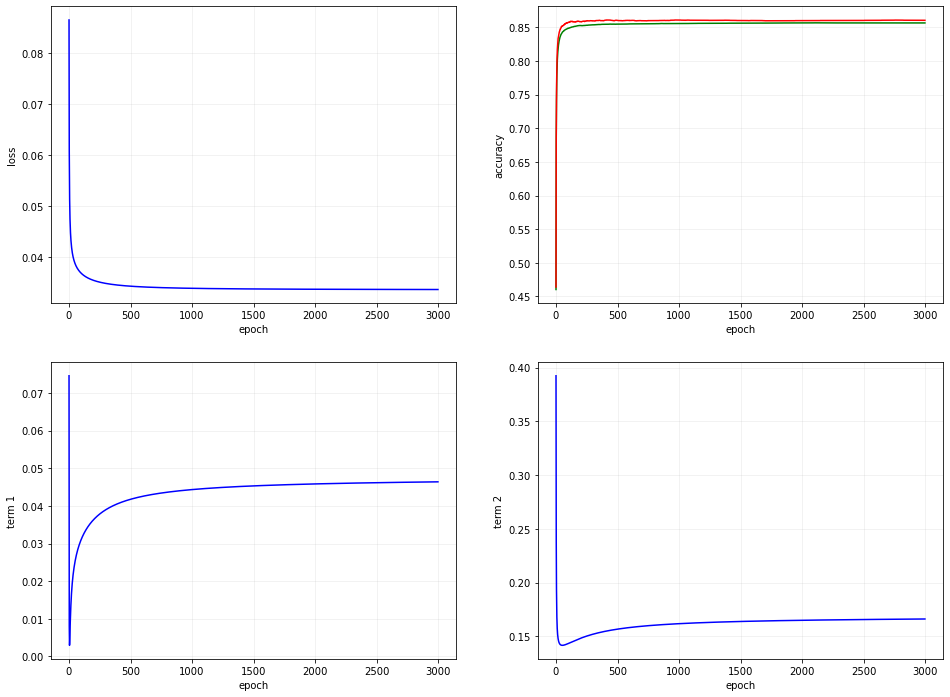

In [8]:
fig, axs = plt.subplots(2, 2, figsize = (16, 12))

axs[0][0].plot(loss_tab, color='blue')
axs[0][1].plot(train_accuracy_tab, color='green')
axs[0][1].plot(test_accuracy_tab, color='red')

axs[1][0].plot(term_I_tab, color = 'blue')
axs[1][1].plot(term_II_tab, color = 'blue')

for row in axs:
    for ax in row:
        ax.grid(True, alpha =0.2)
        ax.set_xlabel('epoch')
        #ax.set_yscale('log')

axs[0][0].set_ylabel('loss')
axs[0][1].set_ylabel('accuracy')
axs[1][0].set_ylabel('term 1')
axs[1][1].set_ylabel('term 2')
plt.show()



In [12]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(255/256, 1, N)    ## red  255,192, 203
vals[:, 1] = np.linspace(192/256, 1, N)
vals[:, 2] = np.linspace(203/256, 1, N)  ## blue 75, 0, 130
Pinks = ListedColormap(vals)


top = cm.get_cmap(Pinks, 256)
bottom = cm.get_cmap('Purples', 256)

newcolors = np.vstack((top(np.linspace(0, 1, 256)),
                       bottom(np.linspace(0, 1, 256))))

newcmp = ListedColormap(newcolors, name='PinkPueple')

## Visualization of mapping of the model

In [13]:
params=[]
for param in model.parameters():
    params.append(param.detach().numpy())
w1=params[0] 
w2=params[1]

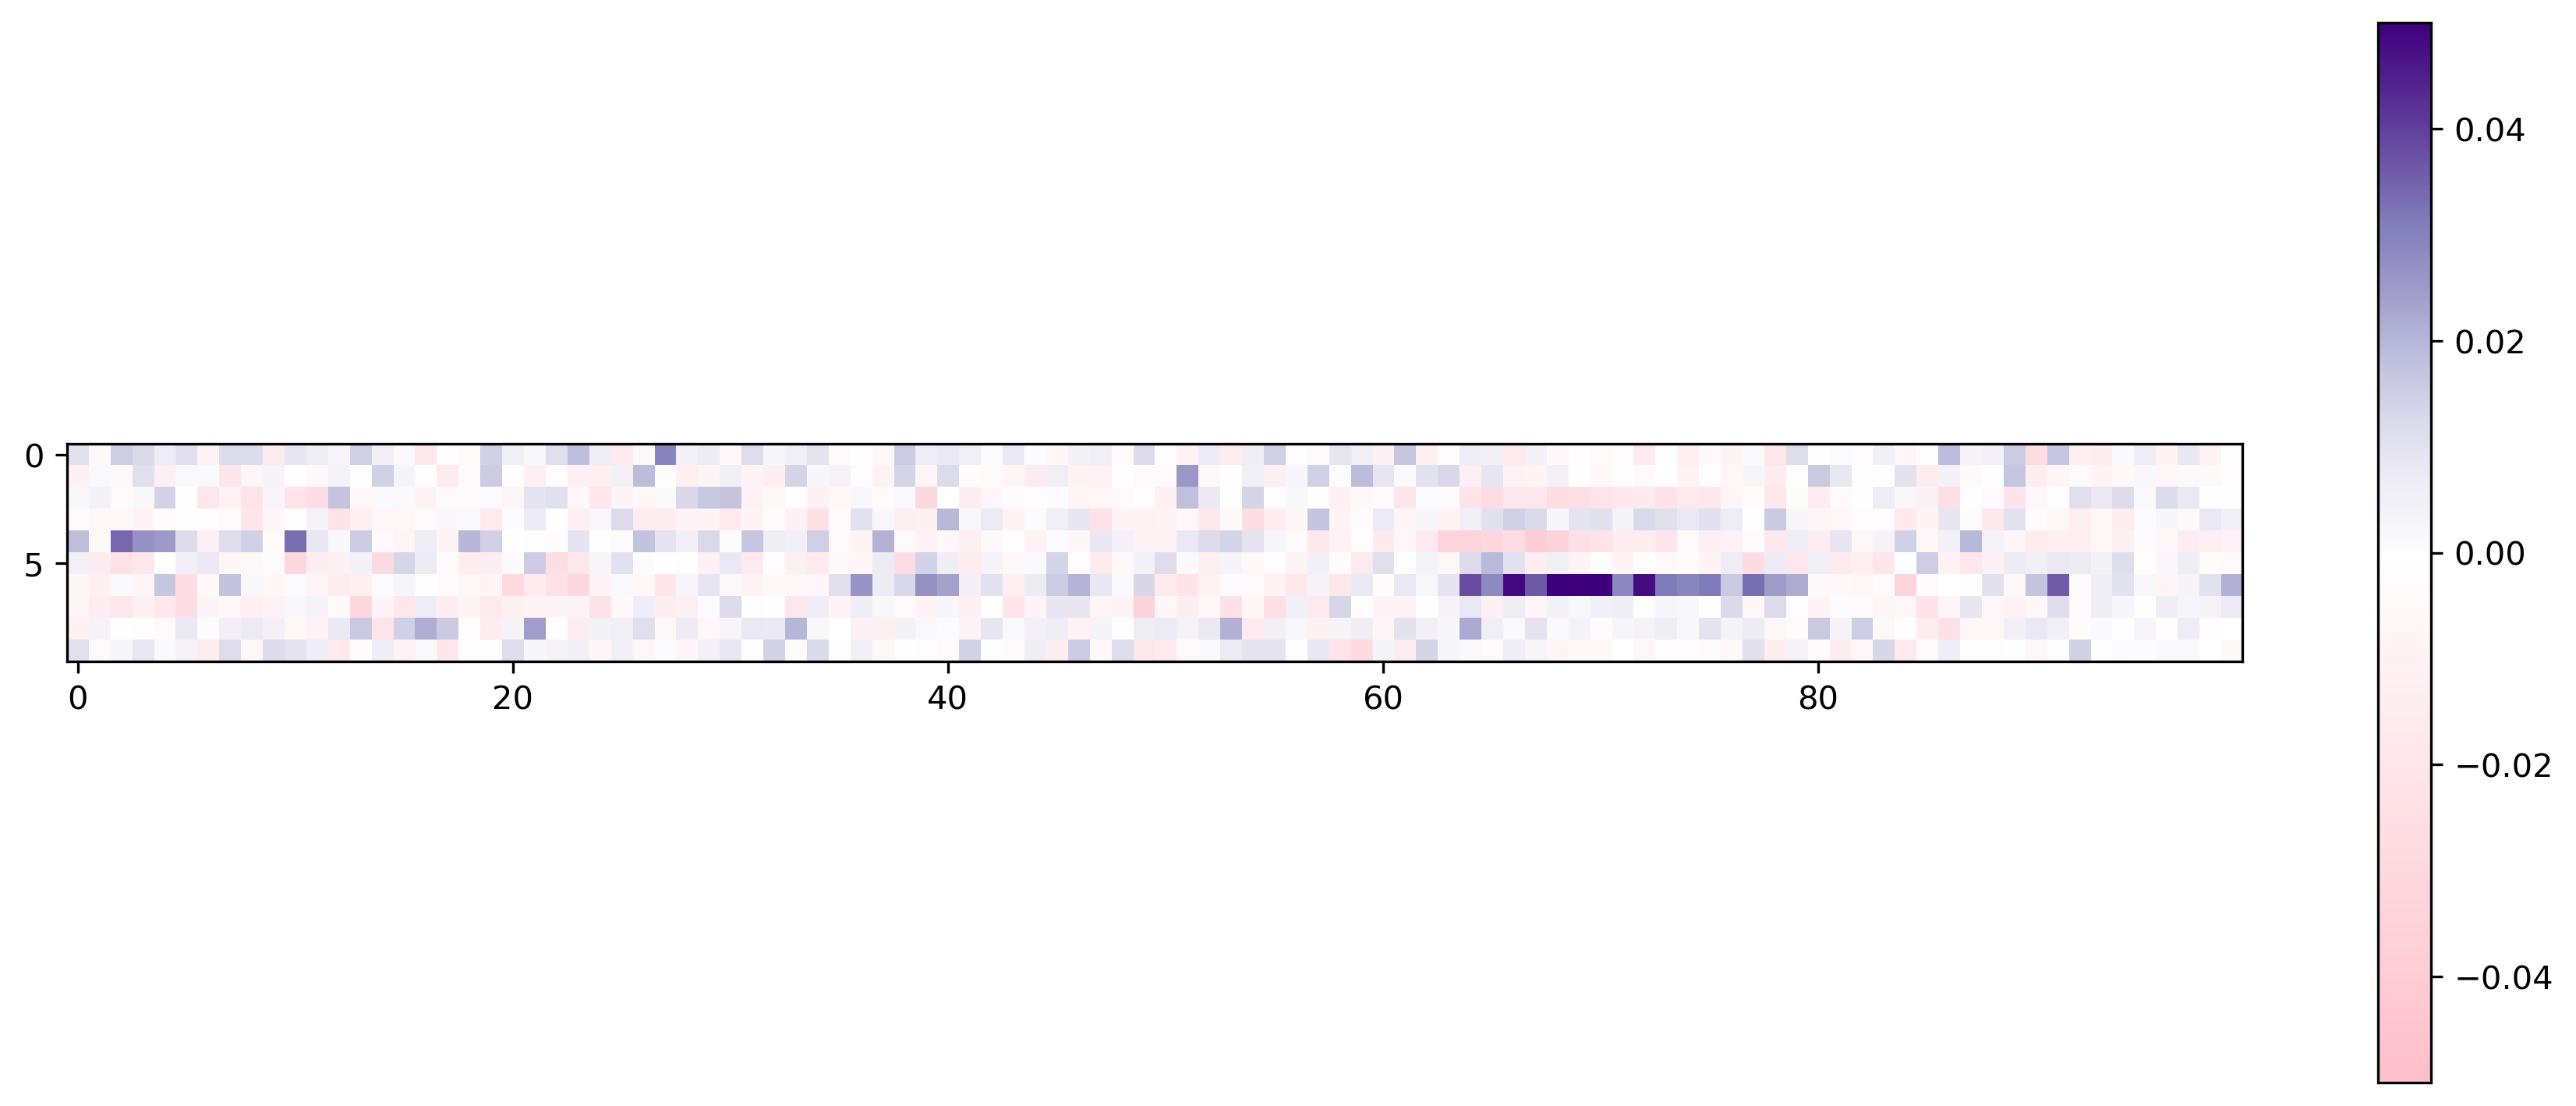

In [14]:
from matplotlib.pyplot import figure
figure(figsize=(15, 6), dpi=300)

WW =  w2 @ w1 
plt.imshow( WW[:100,:100], cmap = newcmp, vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.show()

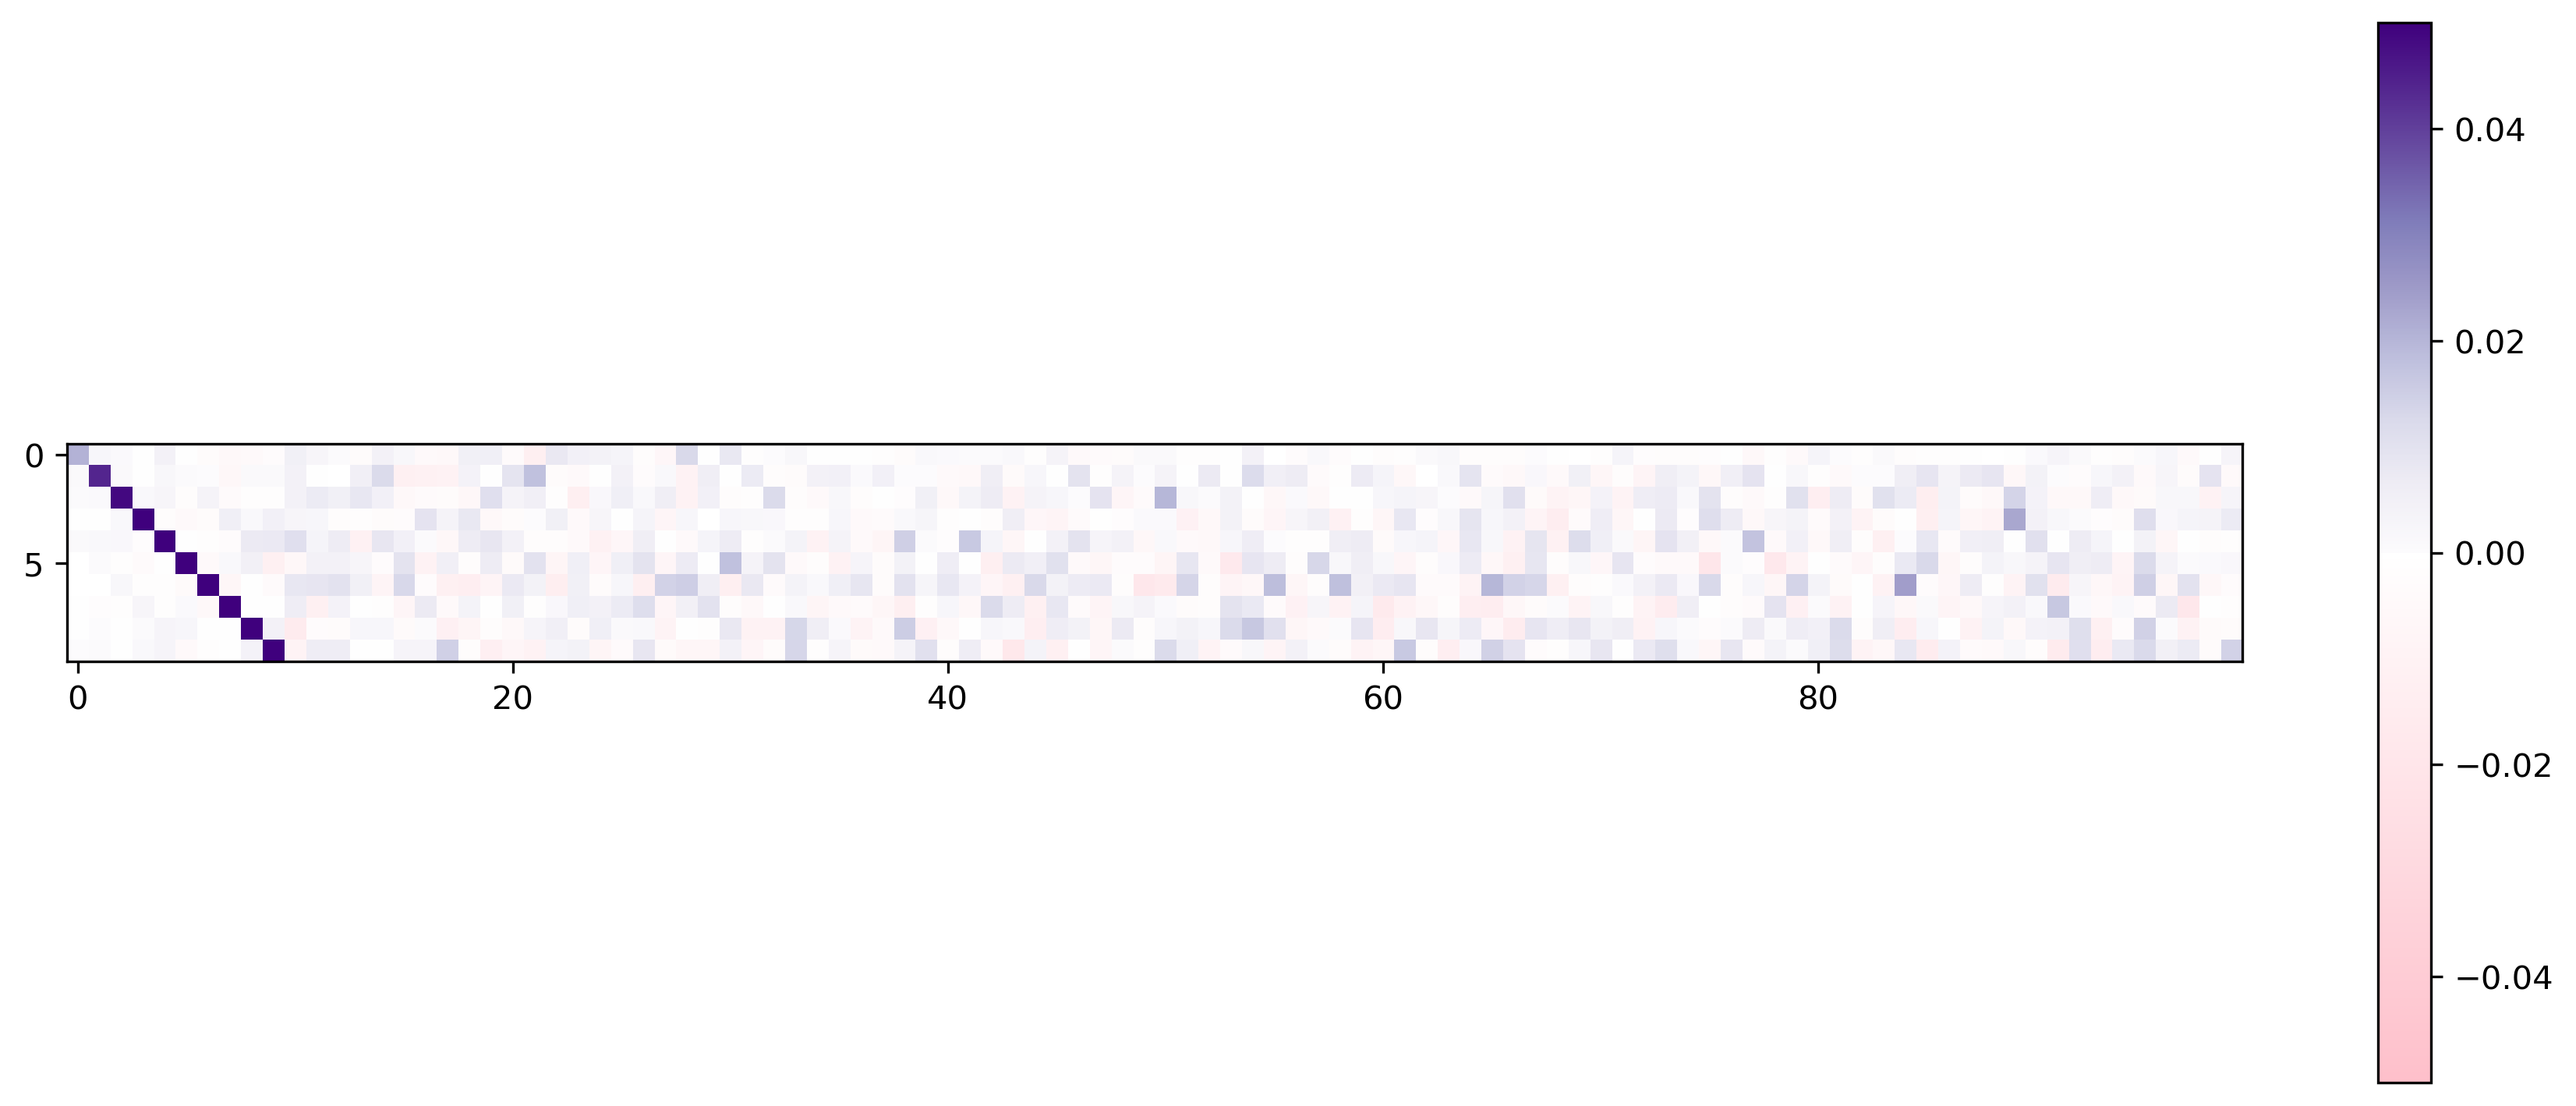

In [15]:
from matplotlib.pyplot import figure
figure(figsize=(15, 6), dpi=300)

WW = U_matrix.T @ w2 @ w1 @ V_matrix
plt.imshow( WW[:100,:100], cmap = newcmp, vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.show()


CHECK: $$MSE = \frac{1}{P} \sum_{\mu=1}^P \lVert y-\hat{y} \rVert ^2 $$
$$ MSE= \frac{1}{P} \sum_{\mu=1}^P \lVert y - W^2 W^1 x \rVert ^2 $$ 

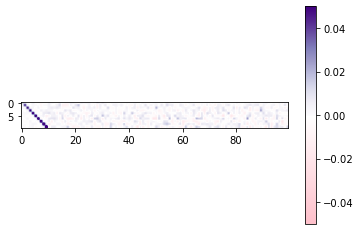

In [16]:
R = U_matrix.T @ w2 @ w1 @ V_matrix
plt.imshow( R[:, :100], cmap = newcmp, vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.show()

## Calculation of terms

In [17]:
term_1 = 0
for alpha in range(10):
    term_1 += (R[alpha][alpha] - S31_matrix[alpha]/S11_matrix[alpha][alpha])**2 * S11_matrix[alpha][alpha]
term_1



array([0.04642036])

In [18]:
term_2 = 0
for beta in range(10):
    for alpha in range(784):
        if(alpha != beta):
            term_2 += (R[beta][alpha])**2 *S11_matrix[alpha][alpha]
term_2


0.1660861720792858

In [19]:
term_3 = np.trace(S33_matrix)
term_3

1.000000009

In [21]:
term_1+term_2+term_3-term_4

array([0.71533023])

In [22]:
term_3-term_4

array([0.50282369])

## terms with star: $T_1^*$,  $T_2^*$,  $T_4^*$

In [23]:
term_4 = 0
for alpha in range(10):
    term_4+= (R[alpha][alpha])**2*S11_matrix[alpha][alpha]
term_4   

0.7861943235617577

In [24]:
term_3-term_4

0.2138056854382424

In [25]:
term_2+term_3-term_4

0.3798918575175283

In [26]:
term_1+term_2+term_3-term_4

array([0.42631222])

# Final MSE on training / testing dataset


In [27]:
MSE_tab=[]
SE_model_tab=[]
SE_calc_tab=[]

batch_size: int = 1  
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [28]:
with torch.no_grad():
    for i, (x,y) in enumerate(train_loader):
        
        y=F.one_hot(y, num_classes=10).float()
        y_model = model(x)
        
        MSE = criterion(y_model, y)
        SE_model = np.linalg.norm(y_model - y)**2
        
        x=x.detach().numpy().flatten()
        y=y.detach().numpy().flatten()
        
        y_calc = w2 @ w1 @ x
        SE_calc = np.linalg.norm(y_calc - y)**2

        MSE_tab.append(float(MSE))
        SE_model_tab.append(float(SE_model))
        SE_calc_tab.append(float(SE_calc))

        #print(i,"\tMSE = {:.6f} \tSE_model = {:.6f}\tSEcalc = {:.6f}".format(MSE, SE_model, SE_calc))
        
mean_MSE = sum(MSE_tab)/len(MSE_tab)
mean_SE_model = sum(SE_model_tab)/len(SE_model_tab)
mean_SE_calc = sum(SE_calc_tab)/len(SE_calc_tab)

print("Mean square error evaluated on training set")
print("MSE = {:.6f} \tMSE_model = {:.6f}\tMSEcalc = {:.6f}".format(mean_MSE, mean_SE_model, mean_SE_calc))

Mean square error evaluated on training set
MSE = 0.038201 	MSE_model = 0.382013	MSEcalc = 0.382013


In [29]:
with torch.no_grad():
    for i, (x,y) in enumerate(test_loader):
        
        y=F.one_hot(y, num_classes=10).float()
        y_model = model(x)
        
        MSE = criterion(y_model, y)
        SE_model = np.linalg.norm(y_model - y)**2
        
        x=x.detach().numpy().flatten()
        y=y.detach().numpy().flatten()
        
        y_calc =  w2 @ w1 @ x
        SE_calc = np.linalg.norm(y_calc - y)**2

        MSE_tab.append(float(MSE))
        SE_model_tab.append(float(SE_model))
        SE_calc_tab.append(float(SE_calc))

        #print(i,"\tMSE = {:.6f} \tSE_model = {:.6f}\tSEcalc = {:.6f}".format(MSE, SE_model, SE_calc))
        
mean_MSE = sum(MSE_tab)/len(MSE_tab)
mean_SE_model = sum(SE_model_tab)/len(SE_model_tab)
mean_SE_calc = sum(SE_calc_tab)/len(SE_calc_tab)

print("Mean square error evaluated on test set")
print("MSE = {:.6f} \tMSE_model = {:.6f}\tMSEcalc = {:.6f}".format(mean_MSE, mean_SE_model, mean_SE_calc))

Mean square error evaluated on test set
MSE = 0.038215 	MSE_model = 0.382147	MSEcalc = 0.382147


# Save all


In [32]:
import pandas as pd

savefile = 'ground_energy_700.csv'
df = pd.DataFrame()

df['loss'] = loss_tab
df['train_accuracy'] = train_accuracy_tab
df['test_accuracy'] = test_accuracy_tab

df['w1_mean'] = w1_mean_tab
df['w1_std'] = w1_std_tab
df['w2_mean'] = w2_mean_tab
df['w2_std'] = w2_std_tab


df['term_I'] = term_I_tab
df['term_II'] = term_II_tab
df['term_IV'] = term_IV_tab
df['R'] = R_tab


df.to_csv(savefile, index=False)

df_w2= pd.DataFrame(np.array(w2_tab).T)
df_w3= pd.DataFrame(np.array(w3_tab).T)

df_w2.to_csv('ground_energy_700_w2.csv', index=False)
df_w3.to_csv('ground_energy_700_w3.csv', index=False)


In [33]:
w1=deepcopy(model.parameters()[0]).detach().numpy().reshape(input_dim*hidden_dim1)
w2=deepcopy(model.parameters()[1]).detach().numpy().reshape(hidden_dim1*output_dim)

df_w1 = pd.DataFrame(w1, columns = ['w1'] )
df_w2 = pd.DataFrame(w2, columns = ['w2'] )

df_w1.to_csv('w1.csv', index=False)
df_w2.to_csv('w2.csv', index=False)
